In [362]:
%run Make_Question_simplified.ipynb
import numpy as np
from collections import defaultdict

import random
import matplotlib.pyplot as plt
#import warnings
#warnings.filterwarnings("ignore")
import time
import csv

In [363]:
N = 2
#M = 5
I = 2
J = 2
K = 3
Data_upperbound = 20
Processing_upperbound = 40


In [364]:
Data_input = Data_Queue(I,J,Data_upperbound)
Data_input_type = Data_Queue_type(I,J,K)
VM_type = VM_Data_type_gen(I,K,N)
VM_speed = VM_Data_processing_speed(Processing_upperbound, VM_type, K)

In [470]:
print(VM_type)
print(Data_input_type)

[[1 2]
 [1 3]]
[[2 1]
 [3 2]]


In [550]:
VM_DP_time = VM_Data_processing_time(Data_input, Data_input_type , VM_speed)
#print(np.shape(VM_DP_time),np.shape( Data_input_type),np.shape(VM_speed))
modified_VM_DP_time =np.copy(VM_DP_time)
modified_VM_DP_time[np.isinf(modified_VM_DP_time)]=50

In [551]:
print(VM_DP_time)
print(modified_VM_DP_time)

[[[ 1. inf]
  [ 2.  1.]]

 [[inf  1.]
  [ 1. inf]]]
[[[ 1. 50.]
  [ 2.  1.]]

 [[50.  1.]
  [ 1. 50.]]]


In [552]:
T_max = little_greedy_algorithm(VM_DP_time,I,J,N)
print(T_max)

4


In [554]:
print("let t = 1 unit of time")

let t = 1 unit of time


In [555]:
position_dictionary, Total = Make_dictionary(I,J,N,T_max)
QUBO_init = np.zeros((Total, Total))
P = 20

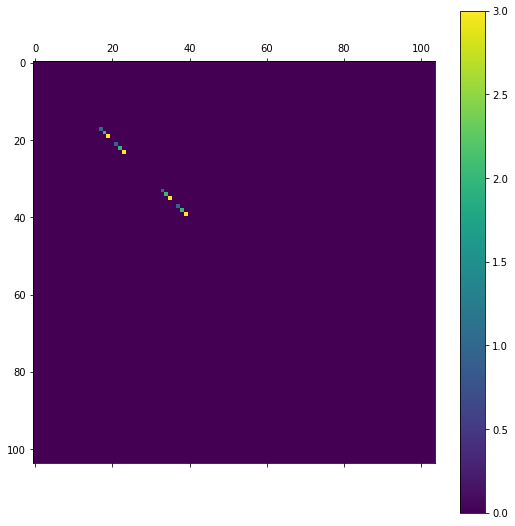

In [556]:
#Obj QUBO dont flatten yet
QUBO_0 = np.zeros_like(QUBO_init)
for i in range(I):    
    for m in range(N):
        for t in range(T_max):
            index_matched = position_dictionary['p_%d%d%d%d'%(i,J-1,m,t)]
            QUBO_0[index_matched,index_matched] += t

#print(QUBO)
show_graph(QUBO_0)

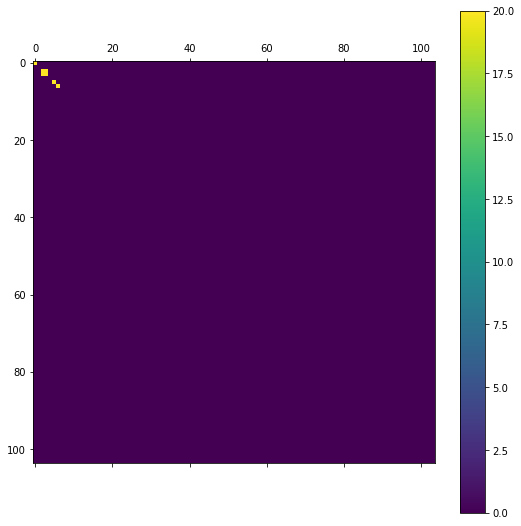

In [557]:
#C1
P1 = np.ones((I,J)) * P
QUBO_1 = np.zeros_like(QUBO_init)
for i in range(I):
    for j in range(J):
        V_ij_k, _ = np.where(VM_type == Data_input_type[i,j])
        index_matched = [];
        for machine in V_ij_k:
            for t in range(T_max):
                index_matched.append(position_dictionary['x_%d%d%d'%(i,j,machine)])
        #print(index_matched)
        x_matched = np.zeros(Total)
        x_matched[np.array(index_matched)] = 1
        QUBO_1 += P1[i,j]*np.outer(x_matched,x_matched)

show_graph(QUBO_1)

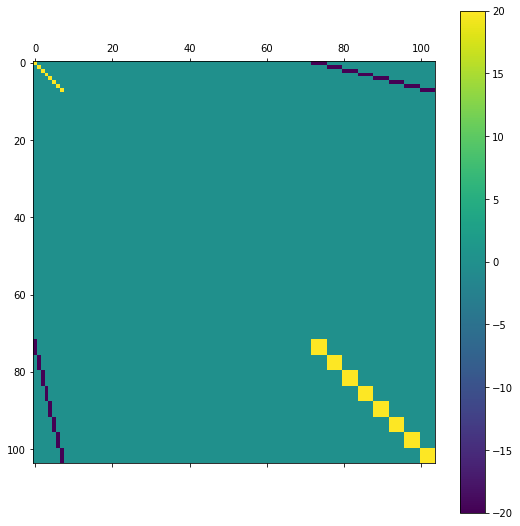

In [558]:
#C2
P2 = np.ones((I,J,N)) * P
QUBO_2 = np.zeros_like(QUBO_init)
for i in range(I):
    for j in range(J):
        for m in range(N):
            index_matched_z = []
            index_matched_x = []
            index_matched_x.append(position_dictionary['x_%d%d%d'%(i,j,m)])
            for t in range(T_max):
                index_matched_z.append(position_dictionary['z_%d%d%d%d'%(i,j,m,t)])
            #print(index_matched)
            var_matched = np.zeros(Total)
            var_matched[np.array(index_matched_z)] = 1
            var_matched[np.array(index_matched_x)] = -1
            QUBO_2 += P2[i,j,m]*np.outer(var_matched,var_matched)

show_graph(QUBO_2)

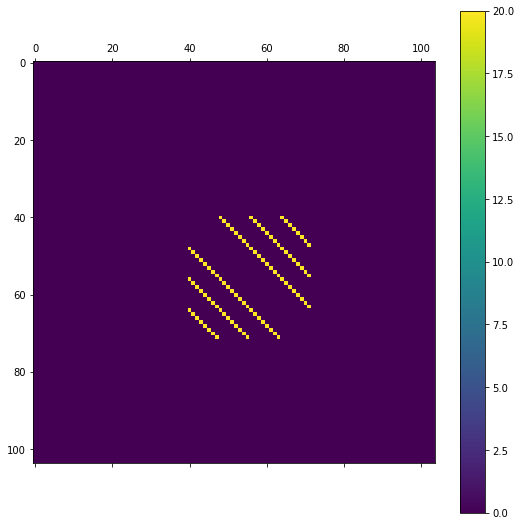

In [559]:
#C3
P3 = np.ones((N,T_max)) * P
QUBO_3 = np.zeros_like(QUBO_init)
for m in range(N):
    for t in range(T_max):
        index_matched = [];
        for i in range(I):
            for j in range(J):
                index_matched.append(position_dictionary['y_%d%d%d%d'%(i,j,m,t)])
        #print(index_matched)
        var_matched = np.zeros(Total)
        var_matched[np.array(index_matched)] = 1
        QUBO_3 += P3[m,t]*(np.outer(var_matched,var_matched)-np.diag(var_matched))

show_graph(QUBO_3)

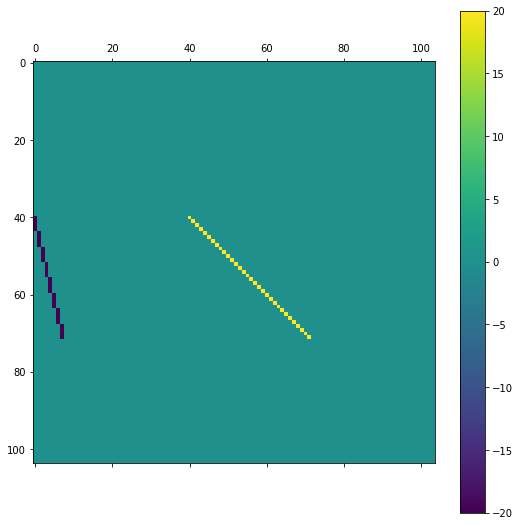

In [560]:
#C4
P4 = np.ones((I,J,N,T_max)) * P
QUBO_4 = np.zeros_like(QUBO_init)

for i in range(I):
    for j in range(J):
        for m in range(N):
            for t in range(T_max):
                QUBO_temp = np.zeros_like(QUBO_init)
                index_matched_x = position_dictionary['x_%d%d%d'%(i,j,m)]
            
                index_matched_y = position_dictionary['y_%d%d%d%d'%(i,j,m,t)]
                #print(index_matched)
                QUBO_temp[index_matched_y,index_matched_y] = 1 
                QUBO_temp[index_matched_y,index_matched_x] = -1 
                QUBO_4 += P4[i,j,m,t]*QUBO_temp

show_graph(QUBO_4)

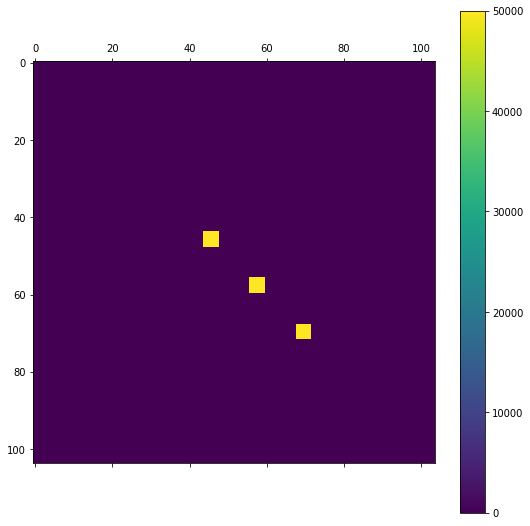

In [561]:
#C5
P5 = np.ones((I,J,N)) * P
QUBO_5 = np.zeros_like(QUBO_init)
for i in range(I):
    for j in range(J):
        for m in range(N):
            index_matched_y = []
            for t in range(T_max):
                index_matched_y.append(position_dictionary['y_%d%d%d%d'%(i,j,m,t)])
                
            var_matched = np.zeros(Total)
            #print(modified_VM_DP_time[i,j,m] )
            #print(index_matched_y)
            var_matched[np.array(index_matched_y)] = modified_VM_DP_time[i,j,m] 
            QUBO_5 += P5[i,j,m]*np.outer(var_matched,var_matched)


show_graph(QUBO_5)

In [562]:
print(modified_VM_DP_time) 

[[[ 1. 50.]
  [ 2.  1.]]

 [[50.  1.]
  [ 1. 50.]]]


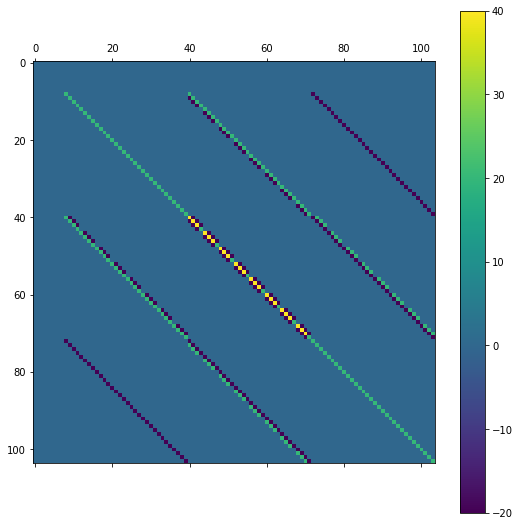

In [563]:
#C6
P6 = np.ones((I,J,N,T_max)) * P
QUBO_6 = np.zeros_like(QUBO_init)
for i in range(I):
    for j in range(J):
        for m in range(N):
            for t in range(T_max):
                if t>0:
                    index_matched_y_pre =  position_dictionary['y_%d%d%d%d'%(i,j,m,t-1)]
                index_matched_y =  position_dictionary['y_%d%d%d%d'%(i,j,m,t)]
                index_matched_z =  position_dictionary['z_%d%d%d%d'%(i,j,m,t)]
                index_matched_p =  position_dictionary['p_%d%d%d%d'%(i,j,m,t)]
                
                var_matched = np.zeros(Total)
                
                if t>0:
                    var_matched[index_matched_y_pre] = 1
                var_matched[index_matched_y] = -1
                var_matched[index_matched_z ] = 1
                var_matched[index_matched_p ] = -1
                
                QUBO_6 += P6[i,j,m,t]*np.outer(var_matched,var_matched)


show_graph(QUBO_6)

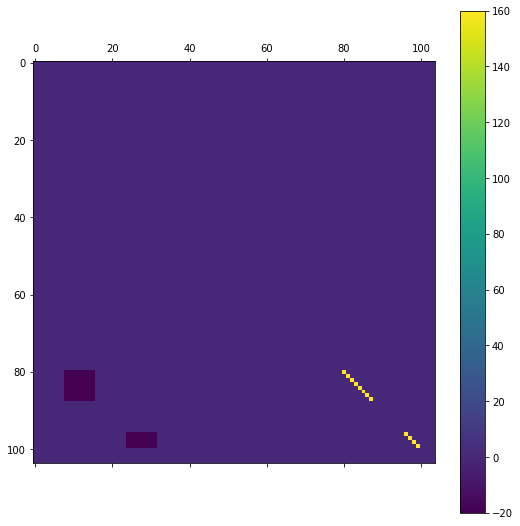

In [564]:
#C7
P7 = np.ones((I,J,N,T_max,T_max)) * P
QUBO_7 = np.zeros_like(QUBO_init)

for i in range(I):
    for j in range(J-1):
        for m in range(N):
            for t in range(T_max):
                for t_prime in range(T_max):
                    V_ijplus1_k, _ = np.where(VM_type == Data_input_type[i,j+1])
                    for machine in V_ijplus1_k:
                        
                        QUBO_temp = np.zeros_like(QUBO_init)
                        
                        index_matched_z = position_dictionary['z_%d%d%d%d'%(i,j+1,machine,t_prime)]

                        index_matched_p = position_dictionary['p_%d%d%d%d'%(i,j,m,t)]
                        #print(index_matched)
                        QUBO_temp[index_matched_z,index_matched_z] = 1 
                        QUBO_temp[index_matched_z,index_matched_p] = -1 
                        QUBO_7 += P7[i,j,m,t,t_prime]*QUBO_temp

show_graph(QUBO_7)

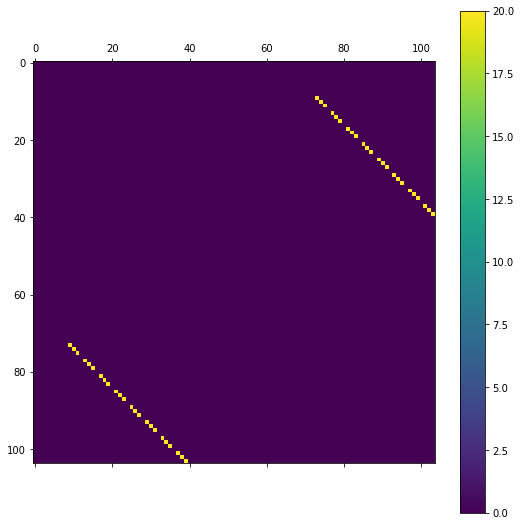

In [565]:
#C8
P8 = np.ones((I,J,N,T_max)) * P
QUBO_8 = np.zeros_like(QUBO_init)
for i in range(I):
    for j in range(J):
        for m in range(N):
            for t in range(1,T_max):
                index_matched_z =  position_dictionary['z_%d%d%d%d'%(i,j,m,t)]
                index_matched_p =  position_dictionary['p_%d%d%d%d'%(i,j,m,t)]
                
                var_matched = np.zeros(Total)

                var_matched[index_matched_z ] = 1
                var_matched[index_matched_p ] = 1
                
                QUBO_8 += P8[i,j,m,t]*(np.outer(var_matched,var_matched)-np.diag(var_matched))


show_graph(QUBO_8)

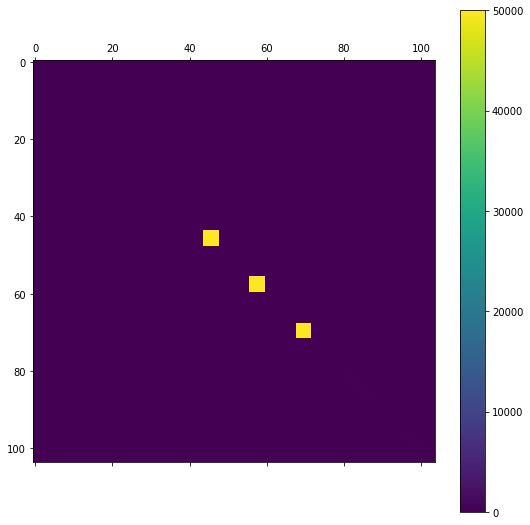

In [566]:
QUBO = np.zeros_like(QUBO_init)
QUBO = QUBO_0 + QUBO_1 + QUBO_2 + QUBO_3 + QUBO_4 + QUBO_5 + QUBO_6 + QUBO_7 + QUBO_8
show_graph(QUBO) 

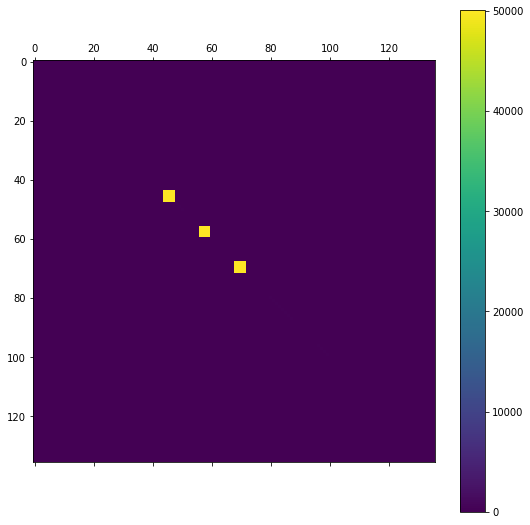

In [567]:
## Single Slack Variable part
#C9

constraint = 9
P9 = np.ones((I,J,N,T_max)) * P
for i in range(I):
    for j in range(J):
        for m in range(N):
            for t in range(T_max):
                index_matched_y = []
                index_matched_y.append(position_dictionary['y_%d%d%d%d'%(i,j,m,t)])                
                
                alpha = 0
                index_matched_z = []
                for alpha in range(1,int(modified_VM_DP_time[i,j,m])+1):
                    index_matched_z.append(position_dictionary['z_%d%d%d%d'%(i,j,m,max(t-alpha+1,0))])
                
                #slack var
                #print(np.shape(QUBO))
                if (alpha <= 0):
                    continue
                else:    
                    position_dictionary["s_%d_%d%d%d%d"%(constraint,i,j,m,t)] = Total
                    Total += 1
                    QUBO = np.pad(QUBO, [(0, 1), (0, 1)], mode='constant', constant_values = 0)
                    #print(np.shape(QUBO))
                    #
                
                    #print(len(position_dictionary))
                    var_matched = np.zeros(Total)
                    var_matched[index_matched_y] = -1
                    var_matched[np.unique(index_matched_z)] = 1
                    var_matched[-1] = 1
                    QUBO += P9[i,j,m,t]*np.outer(var_matched,var_matched)
                
show_graph(QUBO) 

In [568]:
from collections import defaultdict

from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite
import networkx as nx
import numpy as np
import dwave.inspector
import dimod

import matplotlib
matplotlib.use("agg")
from matplotlib import pyplot as plt

In [569]:
#from dwave.system import LeapHybridSampler
width,height = np.shape(QUBO)

QUBO_dictionary = defaultdict(int)
for i in range(width):
    for j in range(height):
        QUBO_dictionary[(i,j)] = QUBO[i,j]

# Select a solver
#sampler = LeapHybridSampler()



# ------- Run our QUBO on the QPU -------
# Set up QPU parameters
#chainstrength = 8
#numruns = 3  #Max =1e4 , a Complex problem needs more numruns 

#response = sampler.sample_qubo(QUBO)


#dwave_sampler = EmbeddingComposite(DWaveSampler(solver={'qpu': True}))
#bqm = dimod.BinaryQuadraticModel.from_qubo(QUBO)
#sampleset = dwave_sampler.sample(bqm, num_reads=1000)



#sampler = EmbeddingComposite(DWaveSampler(solver='DW_2000Q_6'))
#response = sampler.sample_qubo(QUBO_dictionary, chain_strength=chainstrength, num_reads=numruns)


In [570]:
'''
import hybrid
workflow = hybrid.Loop(
   hybrid.RacingBranches(
      hybrid.InterruptableTabuSampler(),
      hybrid.EnergyImpactDecomposer(size=30, rolling=True, rolling_history=0.75)
      | hybrid.QPUSubproblemAutoEmbeddingSampler()
      | hybrid.SplatComposer()) | hybrid.ArgMin(), convergence=3)
bqm = dimod.BinaryQuadraticModel.from_qubo(QUBO)
result = hybrid.HybridSampler(workflow).sample(bqm)  
'''
#print("Solution: sample={}".format(result.first)) 

c = 1

In [571]:
import dwave.inspector
sampler = EmbeddingComposite(DWaveSampler(solver={'qpu': True}))

num_reads = 10000
sampleset = sampler.sample_qubo(QUBO, num_reads=num_reads)

In [572]:
print(sampleset)

      0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 ... 135  energy num_oc. ...
2286  0  0  1  1  1  0  0  1  1  0  0  0  1  1  0 ...   0  1886.0       1 ...
9174  1  0  0  1  1  0  1  1  0  1  0  1  0  1  1 ...   1  2049.0       1 ...
8415  0  1  0  0  1  1  0  0  1  1  1  1  1  1  0 ...   0  2094.0       1 ...
2572  1  1  0  1  1  1  0  0  0  1  1  1  1  0  1 ...   1  2131.0       1 ...
2665  1  1  0  1  0  0  0  0  0  1  0  0  0  1  0 ...   0  2174.0       1 ...
1     1  0  1  1  1  1  1  1  1  1  1  1  0  0  1 ...   1  2185.0       1 ...
25    0  1  1  0  1  1  1  1  0  1  1  1  0  1  0 ...   0  2208.0       1 ...
2607  1  1  1  1  1  1  0  1  1  1  0  0  1  1  1 ...   0  2212.0       1 ...
2965  0  0  1  0  0  1  1  1  1  0  1  0  1  1  0 ...   1  2216.0       1 ...
1130  0  1  0  1  0  1  1  1  0  1  0  0  1  1  0 ...   1  2258.0       1 ...
33    0  0  0  0  1  1  1  1  1  1  1  0  0  0  0 ...   0  2268.0       1 ...
9556  0  1  0  1  1  1  0  0  0  1  1  0  1  0  1 ...   1  2273.

In [573]:
sample = sampleset.first.sample
energy = sampleset.first.energy
print(sample,energy)

{0: 0, 1: 0, 2: 1, 3: 1, 4: 1, 5: 0, 6: 0, 7: 1, 8: 1, 9: 0, 10: 0, 11: 0, 12: 1, 13: 1, 14: 0, 15: 0, 16: 1, 17: 0, 18: 0, 19: 1, 20: 1, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 0, 32: 0, 33: 1, 34: 1, 35: 0, 36: 1, 37: 0, 38: 0, 39: 0, 40: 0, 41: 1, 42: 1, 43: 0, 44: 0, 45: 0, 46: 0, 47: 0, 48: 0, 49: 0, 50: 0, 51: 1, 52: 0, 53: 0, 54: 0, 55: 0, 56: 0, 57: 0, 58: 0, 59: 0, 60: 1, 61: 1, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 67: 1, 68: 0, 69: 0, 70: 0, 71: 0, 72: 1, 73: 1, 74: 0, 75: 0, 76: 0, 77: 0, 78: 0, 79: 0, 80: 0, 81: 1, 82: 0, 83: 0, 84: 1, 85: 0, 86: 0, 87: 0, 88: 0, 89: 1, 90: 0, 91: 0, 92: 0, 93: 1, 94: 0, 95: 1, 96: 0, 97: 0, 98: 0, 99: 0, 100: 0, 101: 1, 102: 0, 103: 0, 104: 1, 105: 0, 106: 0, 107: 0, 108: 1, 109: 0, 110: 0, 111: 0, 112: 1, 113: 0, 114: 0, 115: 0, 116: 1, 117: 1, 118: 0, 119: 1, 120: 0, 121: 0, 122: 1, 123: 0, 124: 1, 125: 0, 126: 1, 127: 0, 128: 0, 129: 0, 130: 0, 131: 1, 132: 1, 133: 0, 134: 0, 135: 0} 1886.0


In [574]:
vals = np.fromiter(sample.values(), dtype=int)

In [575]:
vals

array([0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 0])

In [576]:
keys=vals[:I*J*N]
answer = keys.reshape([I,J,N])

print(answer)

[[[0 0]
  [1 1]]

 [[1 0]
  [0 1]]]
